<a href="https://colab.research.google.com/github/zoeziegler2-pixel/QM2/blob/main/notebooks/W03.%20Spatial%20Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spatiotemporal Data

## *Workshop 3*  [![Open In Colab](https://github.com/oballinger/QM2/blob/main/colab-badge.png?raw=1)](https://colab.research.google.com/github/oballinger/QM2/blob/main/notebooks/W03.%20Spatial%20Data.ipynb)


Sometimes the data we work with references points on the earth's surface, unlocking a rich set of analytical possibilities. In today's workshop, we're going to be exploring the effect of the 2020 California Wildfires on air quality across the state. We'll be using real air quality data collected by sensors and combining it with satellite imagery to show how toxic smoke from wildfires swept over America's largest state.

### Aims
- Understanding spatiotemporal data
- Grouping data in pandas
- Manipulating and plotting geographic data


## Background

![](https://image.cnbcfm.com/api/v1/image/106695701-1599664926959-gettyimages-1228423382-AFP_8PL8JF.jpeg?v=1599664969)

The [2020 California wildfire season](https://en.wikipedia.org/wiki/2020_California_wildfires) was record-setting. By the end of the year, 9,917 fires had burned more than 4% of the state's area, making 2020 the largest wildfire season recorded in California's modern history. California's August Complex fire has been described as the first "gigafire", burning over 1 million acres across seven counties, an area larger than the state of Rhode Island. The fires destroyed over 10,000 structures and cost over \$12.079 billion (2020 USD) in damages, including over \$10 billion in property damage and \$2.079 billion in fire suppression costs. The intensity of the fire season has been attributed to a combination of more than a century of poor forest management and higher temperatures resulting from climate change.

The fires also had a [profound effect on air quality](https://epic.uchicago.edu/news/pollution-from-californias-2020-wildfires-likely-offset-decades-of-air-quality-gains/): “Places that are experiencing frequent or more frequent wildfires are going to experience higher air pollution levels, not just for a couple of days or weeks, but it could impact the annual level of exposure,” said Christa Hasenkopf, director of air quality programs at the University of Chicago institute. “It can bump up that average to unsafe and unhealthy levels that really do have an impact on people’s health. When we think of wildfires, we think of short-term events — and hopefully they are — but they can have long-term consequences considering your overall air pollution exposure.”


## Getting Started

Let's begin by installing some libraries that we'll be working with today.

In [1]:
%%capture
!pip install Basemap
!pip install ipyleaflet

## Importing Libraries

The first step in any python script is to import the necessary libraries:

In [21]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab
from datetime import datetime

%matplotlib inline
pylab.rcParams['figure.figsize'] = (10, 8)

## Downloading Data

The next step is to import the data that we need for our analysis. This week we'll be using real data collected in 2020 by the [Environmental Protection Agency (EPA)](https://www.epa.gov/outdoor-air-quality-data/download-daily-data). I've generated a .csv file containing the data that I want using the dropdown menus. The EPA also has an [Application Programming Interface](https://aqs.epa.gov/aqsweb/documents/data_api.html) for air quality data, which you could use to pull in data directly into python without having to download a .csv!

In [3]:
!mkdir data
!mkdir data/wk3
!curl https://qm2.s3.eu-west-2.amazonaws.com/wk3/california_aqi.csv -o ./data/wk3/california_aqi.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 5586k  100 5586k    0     0  3467k      0  0:00:01  0:00:01 --:--:-- 3469k


Let's open the .csv file and have a look at it:

In [4]:
df=pd.read_csv('data/wk3/california_aqi.csv')
df

,Date,Site ID,POC,PM,AQI,Site Name,CBSA_NAME,COUNTY,latitude,longitude
0,1/1/20,60010007,3,8.6,36,Livermore,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217
1,1/2/20,60010007,3,4.5,19,Livermore,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217
2,1/3/20,60010007,3,14.2,55,Livermore,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217
3,1/4/20,60010007,3,10.9,45,Livermore,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217
4,1/5/20,60010007,3,7.8,33,Livermore,"San Francisco-Oakland-Hayward, CA",Alameda,37.687526,-121.784217
...,...,...,...,...,...,...,...,...,...,...
55686,11/29/20,61131003,1,20.3,68,Woodland-Gibson Road,"Sacramento--Roseville--Arden-Arcade, CA",Yolo,38.661210,-121.732690
55687,12/18/20,61131003,1,2.8,12,Woodland-Gibson Road,"Sacramento--Roseville--Arden-Arcade, CA",Yolo,38.661210,-121.732690
55688,12/20/20,61131003,1,22.4,73,Woodland-Gibson Road,"Sacramento--Roseville--Arden-Arcade, CA",Yolo,38.661210,-121.732690
55689,12/23/20,61131003,1,11.8,49,Woodland-Gibson Road,"Sacramento--Roseville--Arden-Arcade, CA",Yolo,38.661210,-121.732690


Each row in this dataset is an individual reading from an air quality sensor. The first row is a reading from sensor number 60010007 on January 1st 2020. It is located in Alameda County, and recorded an Air Quality Index (AQI) reading of 36. So for each sensor (uniquely identified by the Site ID column) we will have 365 readings. We also have the latitude and longitude of each one of these air quality sensors. The presence of these fields makes this **spatio-temporal** data. We'll first analyze the temporal dimension of our data, before adding in the spatial dimension

##  Temporal Data

Before we go any further, we need to focus on a very special column in our dataset: the "Date" column. We'll be relying heavily on this dimension of our dataset. Whenever we have temporal data, the first thing we want to do is check whether pandas is storing it as datetime information or as a string (text). We can do this using the `dtype` function.

In [5]:
print('Prior to cleaning, the data type of the "Date" column is:', df['Date'].dtype)

df['Date']=pd.to_datetime(df['Date'])

print('Now, it is stored as: ', df['Date'].dtype)

Prior to cleaning, the data type of the "Date" column is: object


/tmp/ipython-input-565488814.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date']=pd.to_datetime(df['Date'])


Now, it is stored as:  datetime64[ns]


Once we've stored the Date column as datetime information, we can do all sorts of useful things with it. For example, we can quickly extract the month from the date, or even the "day of year" (i.e., how many days since January 1st of that year have passed). Try doing that in one line of code if your "Date" column is stored as text!

In [6]:
# we can extract the month from the Date column and save it as a new column
df['Month']=df['Date'].dt.month
# we can do the same for the day of year.
df['Day']=df['Date'].dt.dayofyear

print(df[['Date','Month','Day']])

            Date  Month  Day
0     2020-01-01      1    1
1     2020-01-02      1    2
2     2020-01-03      1    3
3     2020-01-04      1    4
4     2020-01-05      1    5
...          ...    ...  ...
55686 2020-11-29     11  334
55687 2020-12-18     12  353
55688 2020-12-20     12  355
55689 2020-12-23     12  358
55690 2020-12-29     12  364

[55691 rows x 3 columns]


When I print the new columns we've made ("Month" and "Day") next to the original "Date" column, we can see that everything is working as it should. First date (January 1st, 2020), has a value of 1 in the month column, and a 1 in the day column. The last row in the dataset was a sensor reading raken on December 29th, 2020. It has a month of 12, and day-of-year value of 364. Great.

### Exercise

[Here's](https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofyear.html) the documentation for the pandas function that allowed us to extract the day of year from the datetime column. Using the documentation on this page, create a new column in the dataframe that contains the week of year.

### Grouping Data

We can now use the new temporal columns we've created to analyze our data further. The broadest possible question we're interested in today is "What was the effect of the 2020 wildfires on air quality in California?" This involves looking at air quality over time, and comparing pre/post wildfire air quality reading.

To translate that into python, we effectively want to calculate the average AQI value for all of the sensors in California each day. We can accomplish this using the `.groupby()` function in pandas. [Here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html) is the documentation page for the function, give it a quick read.

Remember, each row in our dataframe `df` is an individual sensor reading on a given day. We now want a dataframe in which each row is *one day*, representing the average of *all AQI sensors*. We can accomplish that using the following line of code, which has four parts:

`df.groupby('Day')['AQI'].mean()`

1. `df`: the dataframe we want to use
2. `.groupby('Day')`: the groupby function, and the name of the column that we want to group our data by. In this case, we want each row in our new dataset to be one day, so we're using the "Day" column.
3. `['AQI']`: the data that we want to aggregate. Remember, our dataframe has many columns, but we want to calculate the average daily value of AQI.
4. `.mean()`: the method of aggregation. We're calculating the average in this case, but we could also want to take the maximum value (`.max()`), minimum value (`.min()`), median (`.median()`), etc.

Let's look at the output from the line of code above. Remember, whenever we make something new, we must store it somewhere or it disappears! I'm storing this as a new dataframe called "daily".

In [33]:
daily=df.groupby('Date')['AQI'].mean()
daily

,AQI
Date,
2020-01-01,50.255682
2020-01-02,43.300000
2020-01-03,50.437500
2020-01-04,47.224299
2020-01-05,39.240602
...,...
2020-12-27,33.500000
2020-12-28,23.358209
2020-12-29,30.610256


Now we can see that our dataframe has 366 rows, one for each day of the year (2020 was actually a leap year!). Let's plot the daily average of the AQI sensors, along with a dashed vertical line indicating the day a State of Emergency was declared (August 18th).

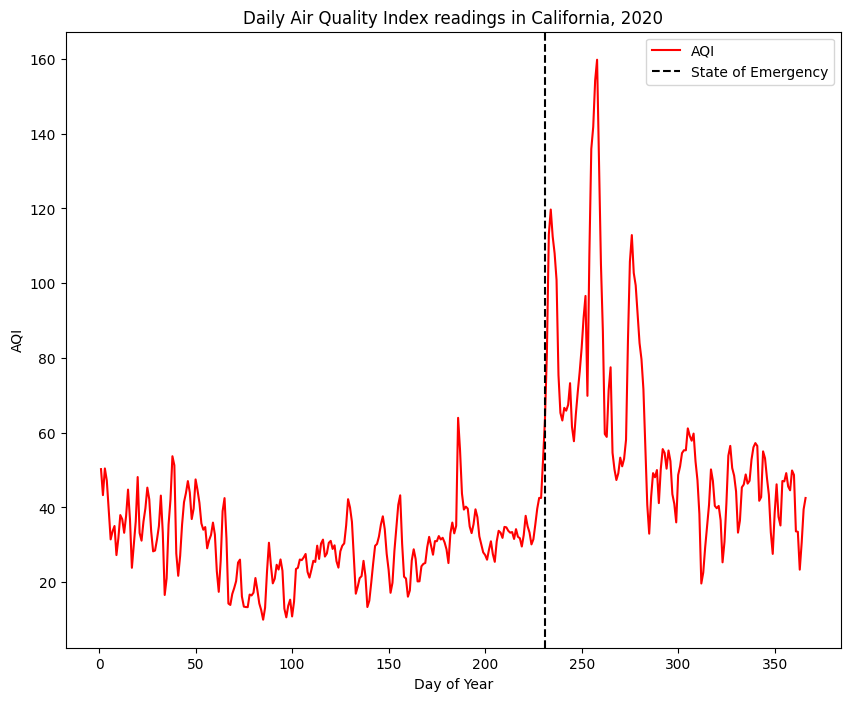

In [8]:
# plot the daily data
daily.plot(color='red')

#add title and axis labels
plt.title('Daily Air Quality Index readings in California, 2020')
plt.ylabel('AQI')
plt.xlabel('Day of Year')

# add a dashed black line on August 18th (the 231st day of the year)
plt.axvline(231, color='black', linestyle='--', label='State of Emergency')
plt.legend()

Pretty cool! We can clearly see some spikes in AQI that correspond directly to when the state of emergency was declared. Our data is matching expectations about reality: even though there's no information about the state of emergency or the wildfires in our dataframe (remember, it's just a bunch of air quality readings from sensors), we observe a relationship between our variables (presence of wildfires and air quality) that conforms to our expectations.

### Exercise
Now, repeat the above plot but aggregate the dataframe by month rather than by day. Store the monthly data as a new dataframe called "monthly".

### Geographic Disparities

OK. We've got a good sense of how the wildfires affected air quality readings across the whole state. But California is huge; there are probably geographic disparities in how bad air quality was as a result of the fires. Let's see which counties were worst affected by the wildfires.  



In our original dataframe, each row was a reading from a given sensor on a given day. We grouped this data by day to create a dataframe that took the average of *all* sensors in california for each day as follows:

`df.groupby('Day')['AQI'].mean()`


Now, we want to plot the average daily air quality by county; this will involve aggregating both by day *and by county*. Intuitively, we can accomplish this changing `'Day'` to `['Day','COUNTY']`, like so:

`df.groupby(['Day','COUNTY'])['AQI'].mean()`

Let's store this new dataframe and call it "county_daily":

In [9]:
county_daily=df.groupby(['Day','COUNTY',])['AQI'].mean().reset_index()
county_daily

,Day,COUNTY,AQI
0,1,Alameda,44.500000
1,1,Butte,66.666667
2,1,Calaveras,63.000000
3,1,Colusa,78.000000
4,1,Contra Costa,46.000000
...,...,...,...
17314,366,Tehama,52.000000
17315,366,Trinity,36.000000
17316,366,Tulare,62.666667
17317,366,Ventura,23.666667


## Exercise

Using the `groupby` function, create a new dataframe called "counties" in which each row is a county, and each value is the **maximum** AQI value in that county during the entire year. Then, sort this dataframe in descending order using `.sort_values(ascending=False)`

Which county had the highest maximum AQI value? Which county had the lowest? store the names of these counties as varables called "highest" and "lowest", shown below:

In [10]:
highest=''
lowest=''

# Filter the county-level daily AQI readings for the worst-affected county
worst_county=county_daily[county_daily['COUNTY']==highest]

# Filter the county-level daily AQI readings for the least-affected county
best_county=county_daily[county_daily['COUNTY']==lowest]

Using those two variables, lets plot the AQI values for each of these counties individually:

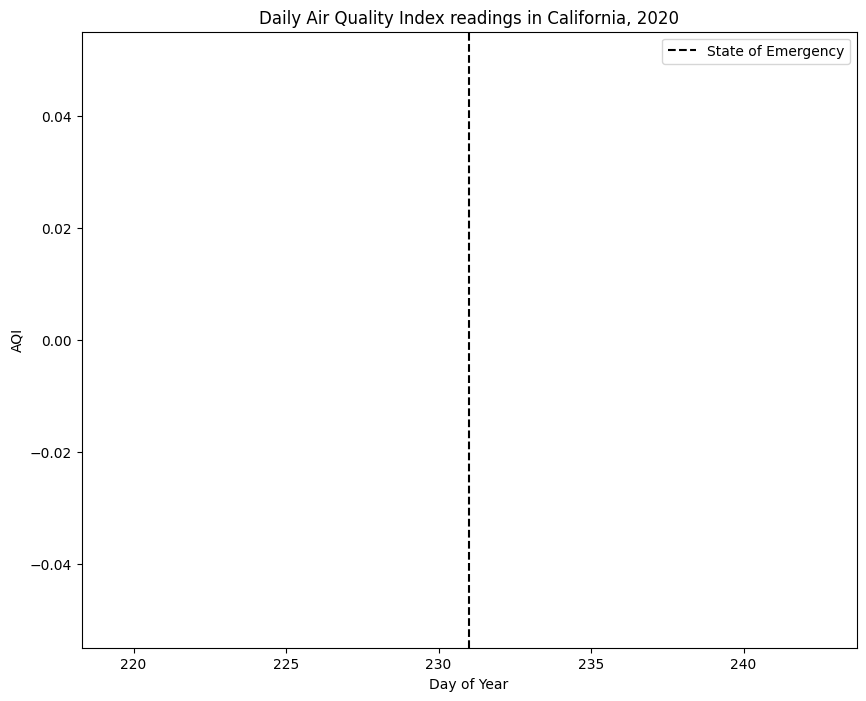

In [11]:
# plot the data from the worst affected county
plt.plot(worst_county['Day'], worst_county['AQI'], label=highest)

# plot the data from the least affected county
plt.plot(best_county['Day'], best_county['AQI'], label=lowest)

#add title and axis labels
plt.title('Daily Air Quality Index readings in California, 2020')
plt.ylabel('AQI')
plt.xlabel('Day of Year')

# add a dashed black line on August 18th (the 231st day of the year)
plt.axvline(231, color='black', linestyle='--', label='State of Emergency')
plt.legend()

We can see that the worst affected county suffered a massive spike in AQI following the wildfires, while the least affected county experienced a much smaller increase in AQI.

## Bringing in Geography

We can explore some limited geographic variation using the "COUNTY" column in our dataframe. But we actually have the latitude and longitude of each individual sensor. We can visualize latitude and longitude data quite simply as a scatterplot.

Remember, in our original dataframe each row is a reading from a given sensor on a given day. The sensor's location does not vary over time, so if we simply plot our original dataframe, we'll have loads of points on top of each other. Let's pick a specific date, take a slice of our dataframe on that one date, and plot it. I've picked September 9th based on the plots above (looks like air quality was really bad).

Text(0.5, 1.0, 'Geographic Distribution of AQI sensors in California')

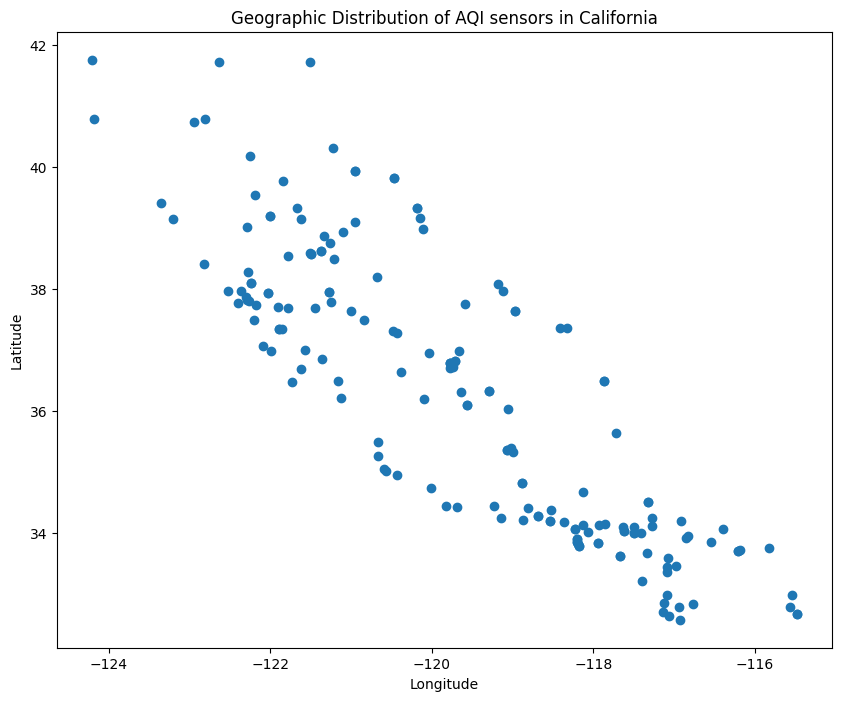

In [12]:
# create a variable with the date of interest, September 9th 2020.
date='09-09-2020'

# filter the original dataframe using this date
one_day=df[df['Date']==date]

# create a scatterplot of sensor locations using latitude and longitude
plt.scatter(
    x=one_day['longitude'],
    y=one_day['latitude'])

# as always, label our axes and the plot!
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Geographic Distribution of AQI sensors in California")

If you close your eyes and imagine the shape of California, you can probably see its outline roughly traced in the points above. This plot leaves a number of things to be desired.

### Basemaps

First, we may want to add in a base map of some kind so we can have a better sense of where each sensor is. For this, we have to import an extra library called "Basemap"

Text(0.5, 1.0, 'Geographic Distribution of AQI sensors in California')

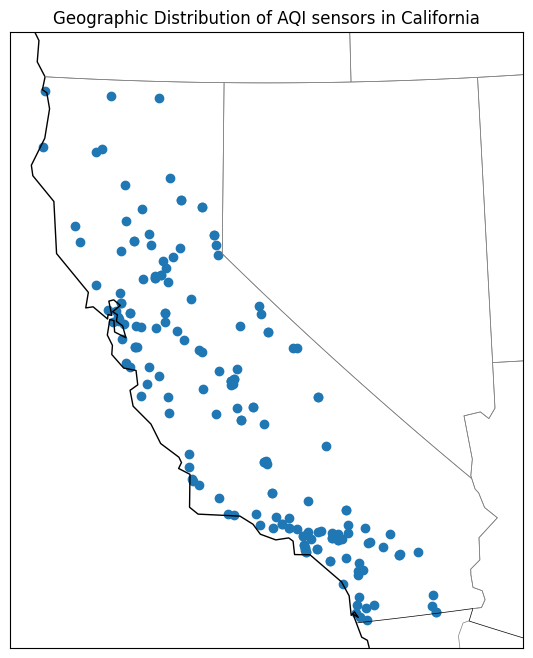

In [13]:
# import Basemap library
from mpl_toolkits.basemap import Basemap

# create a basemap, call it 'map'
map = Basemap(projection='lcc', resolution='l', # this selects the projection of the map.
            lat_0=37.5, lon_0=-119, # this sets the center of the map
            width=1E6, height=1.2E6) # this sets the window that we're looking at, in meters.

# We can add features to our blank basemap, including coastlines, as well as state and country boundaries.
map.drawcoastlines(color='black')
map.drawcountries(color='black')
map.drawstates(color='gray')

# Finally, we add in our AQI sensor data on top of the basemap.
map.scatter(
    one_day['longitude'],
    one_day['latitude'],
    latlon=True)

# as always, title your figure
plt.title("Geographic Distribution of AQI sensors in California")


That's looking a bit better! We now have a much better sense of the actual distribution of these sensors within california. People who know the area will recognize clusters of sensors around San Francisco and Los Angeles; This makes sense, given that these areas have a higher population density. However, our plot is still missing some pretty important information: the actual AQI readings!

### Colormaps

The whole point of plotting these sensors is to understand the spatial distribution of air pollution from the 2020 wildfires.

The EPA published the following [table](https://www.airnow.gov/aqi/aqi-basics/) on their website, which creates a color-coded scale of AQI values that corresponds to the impact thereof on human health.

- AQI under 50 is colored green, and indicates "Good" air quality.
- AQI between 100 and 200 is generally unhealthy
- AQI over 300 is deemed hazardous.

With this in mind, quickly scroll back up to the AQI plots over time. If you did everything correctly, you should notice that the *average* AQI value across all sensors in the worst affected county was over 600!

We'll be using the table from the EPA website to build our own color map. In the code below, I scrape the table and turn it into a "colormap" (basically, a dictionary that associates numbers with colors) that we'll use to color the AQI sensors later.

In [14]:
# scrape the table of AQI values and corresponding colors
# save it as a dataframe called colors
colors=pd.read_html('https://www.airnow.gov/aqi/aqi-basics/')[0]

# create a numerical column for AQI values by splitting the test in the "values of index" column.
# pull out the first string, and convert it to integer
colors['aqi']=colors['Values of Index'].str.split(' ').str[0].astype(int)

# print three columns from the dataframe
print(colors[['aqi','Daily AQI Color','Levels of Concern']])

# create a "colormap" from this dataframe using the "Daily AQI Color" column, and the "aqi" column
aqi_colors=matplotlib.colors.LinearSegmentedColormap.from_list(colors['aqi'],colors['Daily AQI Color'])

   aqi Daily AQI Color               Levels of Concern
0    0           Green                            Good
1   51          Yellow                        Moderate
2  101          Orange  Unhealthy for Sensitive Groups
3  151             Red                       Unhealthy
4  201          Purple                  Very Unhealthy
5  301          Maroon                       Hazardous


Now, we can use this "aqi_colors" object as a color palette later when we plot the AQI sensors. This way, we will know that green and yellow points are OK, while red and purple points represent hazardous levels of air pollution. I've annotated the code above, but it's ok if you don't get all of it. You could simply load a different colormap in one line of code; check out the documentation [here](https://matplotlib.org/stable/tutorials/colors/colormaps.html).

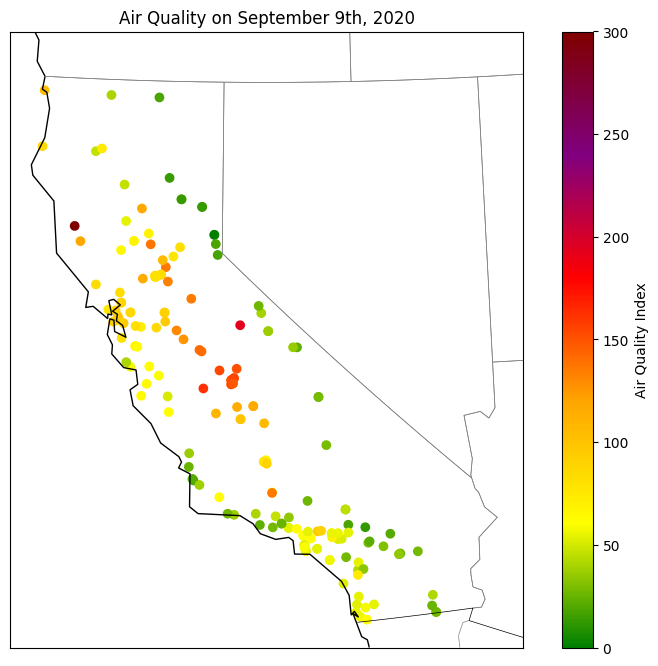

In [15]:
map = Basemap(projection='lcc', resolution='l',
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)

map.drawcoastlines(color='black')
map.drawcountries(color='black')
map.drawstates(color='gray')

map.scatter(
      one_day['longitude'],
      one_day['latitude'],
      latlon=True,
      c=one_day['AQI'], # We're adding that
      cmap=aqi_colors,
      vmin=0,
      vmax=300)


plt.title('Air Quality on September 9th, 2020')
plt.colorbar(label='Air Quality Index');

This plot gives us a good sense of which areas were worst affected by the wildfires on September 9th, 2020. Areas in the central valley suffered particularly bad air quality, with AQI reaching hazardous levels in some areas.

### Exercise

So far, we've been plotting data from one day, using a dataframe we generated by filtering the date column like so: `one_day=df[df['Date']=='09-09-2020']` (date format is day-month-year).

Using the code from the previous cell, generate a plot of AQI on March 2nd, 2020. After that, use the groupby function to generate a plot of the maximum AQI reading for each sensor and plot it.

If you've followed along this far, well done! we've come a long way from a spreadsheet full of sensor readings. But we can go even further!

## Advanced: Satellite Imagery and Interactivity

The AQI plots we've generated above give us a good sense of where the worst air pollution was on a given day; but we're still basically *inferring* the presence of fires. Luckily, we don't have to do that. The plumes of smoke generated by the fires were so vast that they were visible from space. There are a variety of satellites that image the earth each day (some, like GOES-17, take a picture every few minutes!).

NASA's Moderate Resolution Imaging Spectroradiometer (MODIS) satellites take a picture of the same spot on earth nearly every day. So far, we've been looking at September 9th as a particularly bad day for air quality in California. Let's have a look at a satellite image from that day. A Python library called ipyleaflet contains some useful functions that let us pull up an interactive map of satellite imagery.

In [16]:
# import the map making modules from ipyleaflet
from ipyleaflet import Map, Marker, basemaps, basemap_to_tiles,Circle
from ipywidgets import HTML

# let create an interactive Map object called "satellite_map"
satellite_map = Map(
  basemap=basemap_to_tiles( #this function lets us pick from a list of basemaps for our interactive map
    basemaps.NASAGIBS.ModisTerraTrueColorCR, "2020-09-09" # here we're specifying that we want MODIS imagery, and the date that we want it from
  ),
  center=(36.77, -119.41), # then, we want to center the map on california. these coordinates do that
  zoom=5, #finally, we want to set the zoom level of the map.
)

# once we've created the map object we can make it bigger or smaller. let's make it 700 pixels tall.
satellite_map.layout.height = '700px'

# now, we visualize it.
satellite_map

Map(center=[36.77, -119.41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

This is a pretty striking image of the West Coast of the U.S. We can see fluffy white clouds to the East and West, but in the center of the map plumes of brown smoke emanate from wildfires in California and Oregon. Use the + - keys in the top left to zoom in, see if you can spot some wildfires.

### Exercise

Try changing the code in the cell above to display an image from September 15th. You could even try importing a different basemap (like nighttime lights) using this [list of basemaps](https://ipyleaflet.readthedocs.io/en/latest/map_and_basemaps/basemaps.html).

## Combining sensors and satellite images

A cool part of working with spatial data is that we can combine two completeley different datasets using spatial information. We can add the AQI sensor data as points to this map.

In [17]:
# grab the first row from our September 9th dataframe
row=one_day.iloc[0]
print(row)

# This part uses the AQI value in this row (72), and looks up the corresponding color in the colormap we created earlier
color=matplotlib.colors.rgb2hex(aqi_colors(row['AQI']))

# Now we create a Circle object using the latitude and longitude from the row, and color it using the color we just selected
point=Circle(location=(row['latitude'],row['longitude']), color=color)

# Add this as a layer to the satellite_map object
satellite_map.add_layer(point)

# Display the updated map
satellite_map


Date                       2020-09-09 00:00:00
Site ID                               60010007
POC                                          3
PM                                        22.3
AQI                                         72
Site Name                            Livermore
CBSA_NAME    San Francisco-Oakland-Hayward, CA
COUNTY                                 Alameda
latitude                             37.687526
longitude                          -121.784217
Month                                        9
Day                                        253
Name: 249, dtype: object


Map(center=[36.77, -119.41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

It's a bit hard to see, but we've plotted an AQI sensor! its under the cloud of smoke in the center of the map. You can zoom in to get a closer look. looks like AQI was pretty bad at this location.

Having plotted one point, we can now plot all the points on September 9th! to do so, we can use the `iterrows` function in Pandas which, suprisingly, lets you iterate over rows in a dataframe. The first line of code below allows us to iterate over the rows in the `one_day` dataframe. It will then run everything in the indented block for each row; in other words, for each row, it will:

  1. use the row's value in the AQI value to select a color for the point
  2. create a point object using the latitude and longitude columns
  3. add that point to the satellite map.



In [18]:
for index, row in one_day.iterrows():
  color=matplotlib.colors.rgb2hex(aqi_colors(row['AQI']))
  point=Circle(location=(row['latitude'],row['longitude']), color=color)
  satellite_map.add_layer(point)

# display the map
satellite_map

Map(center=[36.77, -119.41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

Theres a pretty striking trend in this data. If you zoom in, you'll see that the AQI sensors to the East are all green since they are up-wind from the fires. A few kilometers downwind of the fires, the AQI sensors display very high readings. Remember, our AQI data and the satellite imagery are derived from totally different sources, and are totally different types of data, but they seem to be telling us the same story. They actually complement each other in important ways. In our original plot of the AQI sensors without satellite imagery, we could tell that there was bad air quality on September 9th, but some sensors were green and others were red. The satellite image shows us that the variation in AQI across California on September 9th was due to the direction of the wind, blowing the smoke from the wildfires westward.

## Extension

Now, to save some hassle we can package all the code we used to generate this map into one clean function. Because we're effectively just changing the date, we can configure this function so that we can feed it a different date, and it will grab a satellite image and filter our dataframe for values occuring on that day. Then, we can draw a new map in one line of code.

In [48]:
def satellite_plot(date):

  ymd=datetime.strptime(date, '%d-%m-%Y').strftime('%Y-%m-%d')

  satellite_map = Map(
    basemap=basemap_to_tiles(
      basemaps.NASAGIBS.ModisTerraTrueColorCR, ymd
    ),
    center=(36.77, -119.41),
    zoom=6,
  )

  satellite_map.layout.height = '700px'

  one_day=df[df['Date']==date]

  for index, row in one_day.iterrows():
    color=matplotlib.colors.rgb2hex(aqi_colors(row['AQI']))
    point=Circle(location=(row['latitude'],row['longitude']), color=color)
    point.popup = HTML(str(row['Site Name']))
    satellite_map.add_layer(point)
  return satellite_map

Now, we can simply change the date in the function and view both satellite imagery and AQI sensor data from a given day. Look at this clear day from February 3rd.

In [20]:
satellite_plot('02-03-2020')

Map(center=[36.77, -119.41], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…

All the AQI sensors are showing green values, indicating generally good air quality. The satellite image shows a few wispy clouds, but no thick yellow smoke. Now change the date to September 15th, and see what happens!

# Assessed Question

Earlier, we created a dataframe called `daily` in which we calculated the average daily AQI across the state for every day of the year. (hint: try re-generating this dataframe using the `Date` column rather than the `Day` column in the `.groupby()` function)

1. Sort that dataframe to figure out which day had the worst AQI.
2. Plug that date into the `satellite_plot()` function to visualize the corresponding satellite image. for the next steps, you'll be modifying the `satellite_plot()` function.
3. Change the basemap to show strava running activity rather than satellite imagery. You can find the basemaps [here](https://ipyleaflet.readthedocs.io/en/latest/map_and_basemaps/basemaps.html).
4. Plot the top 5 sensors with the worst air quality on that day. Zoom in and inspect to see whether or not people tend to go for runs in this area.

QUESTION: how many of these sensors show running activity *within* the circle?

In [34]:
worst_aqi=daily.sort_values(ascending=False).index[0]

In [42]:
worst_aqi

Timestamp('2020-09-14 00:00:00')

In [47]:
satellite_plot("14-09-2020")

AttributeError: Empty

In [ ]:
µ